# Implementation of LeNet-5 in PyTorch

This notebook contains an authentic implementation of the LeNet-5 model, described in the paper [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791) by Lecun et al. from 1998.

## Part I: Paper Analysis
### Introduction

The LeNet-5 paper is often recommended for ML beginners to implement. However, this might be quite overwhelming due to the paper's length, complexity and large amount of advanced concepts that are not very used nowadays - it's important to note that for the implementation purpose, only Part II (LeNet-5 description) and Part III (dataset information, results and comparison with other algorithms) are relevant.

Furthermore, the intended implementation (and most of the existing implementations) of LeNet-5 is actually a "simplified" and "modernized" version of the original model - the point being to demonstrate the core ideas behind the architecture by using modern and more relevant implementation using the Conv-Norm-ReLU-Pool blocks. <br />
While I agree that this is a good approach, given that the original architecture contains some outdated techniques, I think it's still interesting to see a more authentic implementation and understand the original architecture and the intentions of the authors.

Therefore, this notebook aims to provide an implementation closer to the original architecture, while referencing the specific parts of the paper. There are still parts that I'll omit due to complexity/relevance, but the main structure is kept roughly the same.


### Dataset
LeNet-5 is trained on the a modified NIST dataset containing images of hand-written digits.
The original NIST dataset was constructed using the "Special Database 3" for training and "Special Database 1" for testing. The modification comes from the fact that the train set is collected from American Census Bureau employees, while the test set from American High School students, and is therefore not ideal for experiments.

Therefore, Modified NIST (MNIST) was created by remixing the NIST sets, resulting in 60 000 training examples and 60 000 test examples. For the experiments described in the paper, full 60k examples were used for training, but only 10k for testing - this is the commonly used version of the MNIST dataset used today.

Furthermore, the original black and white 128x128 digit images were size normalized to 20x20 grayscale images (due to antialiasing). Then, these digits were centered in a 28x28 field, sometimes extended to 32x32 with background (white) pixels - this version is called the "regular database." Another version is referred to as the "deslanted database" in the paper, and contains 20x20 deslanted images. Last version used in some early experiments contained images reduced to 16x16 pixels.

Only the regular database is used in this notebook, below are randomly picked examples from this database:

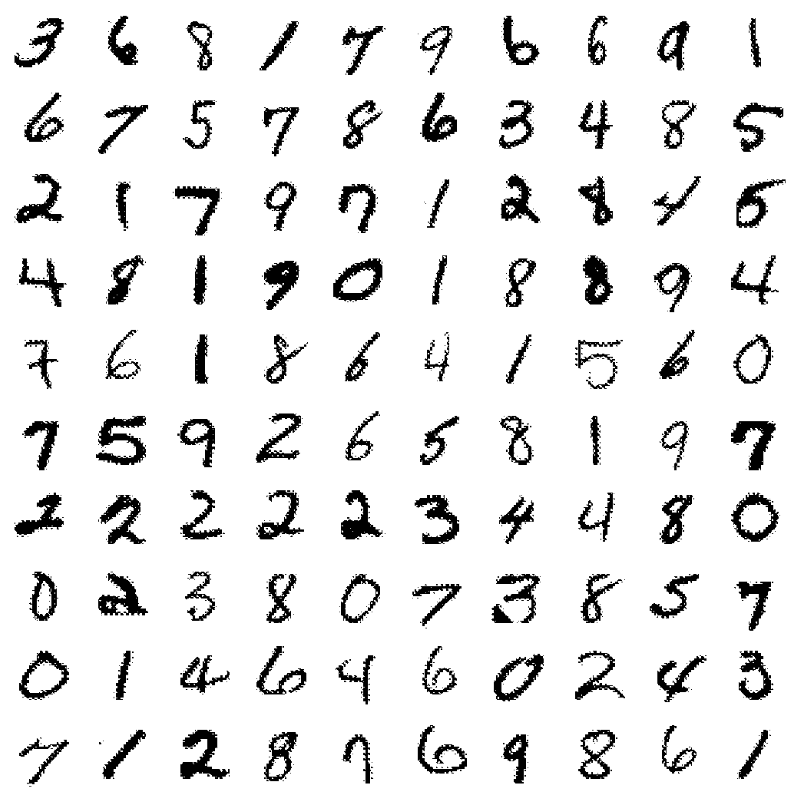

### Architecture

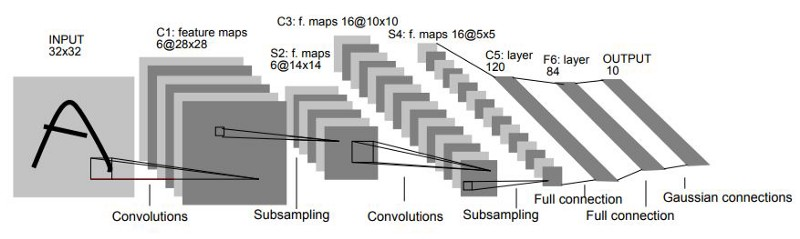

LeNet-5 consists of 7 layers:

0. **Input Layer:**
    - Takes in the normalized images extended from 28x28 to 32x32 (with padding)
1. **C1 - Convolution Layer:**
    - Six 5x5 filters outputting six 28x28 feature maps
2. **S2 - Subsampling/Pooling Layer:**
    - 2x2 subsampling window - the pixels are added together and multiplied by a trainable coefficient and added to a trainable bias
    - Outputs six 14x14 feature maps
    - Note: Pooling layers in modern architectures don't have trainable parameters
3. **C3 - Convolution Layer:**
    - Sixteen 5x5 filters outputting 16 10x10 feature maps
    - Note: Due to limited computational resources of the time (and the goal of breaking symmetry) , there's a specific "connection pattern" in which different filters look at different channels of the input. Such techniques are typically not used today.
4. **S4 - Subsampling/Pooling Layer:**
    - 2x2 subsampling window, same as S2
    - Outputs sixteen 5x5 feature maps
5. **C5 - Convolution Layer:**
    - 120 5x5 filters, outputting 120 1x1 feature maps
    - C5 is fully connected to S4 (i.e. no special pattern was used as in C3)
    - Technically speaking, this is essentially a fully-connected layer - but the convolutional form allows for easy changes in different number/sizes of filters
6. **FC6 - Fully-Connected Layer:**
    - 84 neurons
    - Number of neurons comes from the design of the output layer
7. **Output Layer:**
    - Consists of 10 (based on the number of classes) Euclidian Radial Base Function (RBF) units
    - Each unit computes the Euclidian distance from its input vector and parameter vector
    - Fully connected to the previous 84 neurons

Furthermore, each layer up to FC6 is followed by a sigmoidal function (scaled tanh, see below), that is, both the convolutional and subsampling/pooling layers - this is one of the examples of a technique that is not typically used in modern architectures (non-linearity after pooling AND convolution).

### Training
**<ins>Loss Function</ins>**<br />
- Simplest loss function for the network can be Maximum Likelihood Estimation, which in this case corresponds to Mean Squared Error (MSE)
- However, the paper points out three (two) limitations of such objective for its purpose:
    1. If we keep the params of the RBF layer learnable, the loss has a trivial but unacceptable solution, where all the RBF outputs are 0
    2. Lack of competition between the classes - MSE minimizes the penalty for the correct class but doesn't penalize incorrect classes
    3. Third limitation is mentioned but not described
- Thus, the authors add a log-sum-exp term that mitigates the collapsing effect and enforces competition 
- Furtherore, the log-sum-exp can be interpreted as the unnormalized negative log-likelihood of the correct class under a softmax-like distribution over the RBF distances
- The following is the proposed loss function:
$$
E(W) = \frac{1}{P} \sum_{p=1}^{P} \left( y_{D_p}(Z_p, W) + \log \left( e^{-j} + \sum_{i=1}^{N} e^{-y_i(Z_p, W)} \right) \right)
$$
⟹ where:
- $P$ is the number of training samples (batch size)
- $N$ is the number of classes
- $Z_p$ is the input vector for the $p$-th training sample
- $W$ are the parameters of the network
- $D_P$ is the index of the correct class for the $p$-th sample
- $y_{D_p}(Z_p, W)$ is the distance (or penalty) of the input $Z_p$ from the RBF center corresponding to the correct class $D_p$
- $y_i(Z_p, W)$ is the distance (or penalty) of the input $Z_p$ from the RBF center for class $i$
<br /><br />
- As you can see, there's an additional $e^{-j}$ constant in the log-sum-exp which ensures that very large penalties do not dominate the competition term - it represents a baseline penalty for a "rubbish"/"background" class that acts as a catch-all for patterns that do not belong to any of the known classes
- This essentially introduces regulariztion to stabilize the competition term

**<ins>Optimization</ins>**<br />
The paper uses a complex minimization procedure as the optimizer, described in detail in Appendix B and C. Specifically, the authors "extend" classical Stochastic Gradient Descent with the Stochastic Diagonal Levenberg-Marquardt (SDLM) method. This method involves computing individual learning rates for each parameter based on a diagonal approximation of the second derivative (Hessian) matrix. These learning rates are updated periodically based on the structure of the error surface to improve convergence. While this approach is designed to handle issues like ill-conditioning of the error surface and weight-sharing in convolutional layers, it adds computational overhead and implementation complexity.

Therefore, for simplicity, this implementation uses Stochastic Gradient Descent (SGD) with momentum and larger batch size. This provides a simpler and more widely used optimization approach while still enabling effective convergence. I might add the implementation of the SDLM method in the future.

**<ins>Training Schedule</ins>**<br />
Most experiment were run for 20 epochs with the following learning rate schedule:

| Epochs             | Learning Rate |
|--------------------|---------------|
| First 2 epochs     | 0.0005        |
| Next 3 epochs      | 0.0002        |
| Next 3 epochs      | 0.0001        |
| Next 4 epochs      | 0.00005       |
| Rest of the epochs | 0.00001       |


## Part II: Implementation

In [1]:
# Imports and Device setting

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print(f"Using {device} device")

Using cuda device


### Dataset and Preprocessing
PyTorch already has MNIST dataset available which corresponds to the regular database from the paper. Alternatively, you can check [the original website](http://yann.lecun.com/exdb/mnist/).
It consists of 60k training samples and 10k test samples. Normally, we could split the training set to train and validation parts to track performance during training, but since the aim of this notebook is to replicate the methodology from the original paper, we will skip this step.

**Preprocessing**
The 28x28 images are extended to 32x32 with background pixels. Note this isn't the same as resizing the images to 32x32.
Therefore, we pad the images with 2 pixels during preprocessing, rather than adding a padding in the first layer.

Nowadays, the normalization used on MNIST (based on empirical evidence) is typically done by setting the mean to 0.1307 and standard deviation to 0.3081. However, for the purpose of this notebook, we normalize the images according to the original paper:

> 
> *The values of the input pixels are normalized so that the background level (white) corresponds to a value of and the foreground  (black) corresponds to 1.175. This makes the mean input roughly zero and the variance roughly one, which accelerates learning.*
> 


In [2]:
# Custom normalization according to the original paper

class CustomNormalize(nn.Module):
    def __init__(self):
        super(CustomNormalize, self).__init__()

    def forward(self, x):
        # map 0 to -0.1 and 1 to 1.175
        return x * 1.275 - 0.1

In [3]:
# Dataset

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Pad(2), 
        transforms.ToTensor(),
        CustomNormalize()
    ])
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Pad(2),
        transforms.ToTensor(),
        CustomNormalize()
    ])
)

print(f"Training dataset size: {len(train_data)}")
print(f"Test dataset size: {len(test_data)}")

Training dataset size: 60000
Test dataset size: 10000


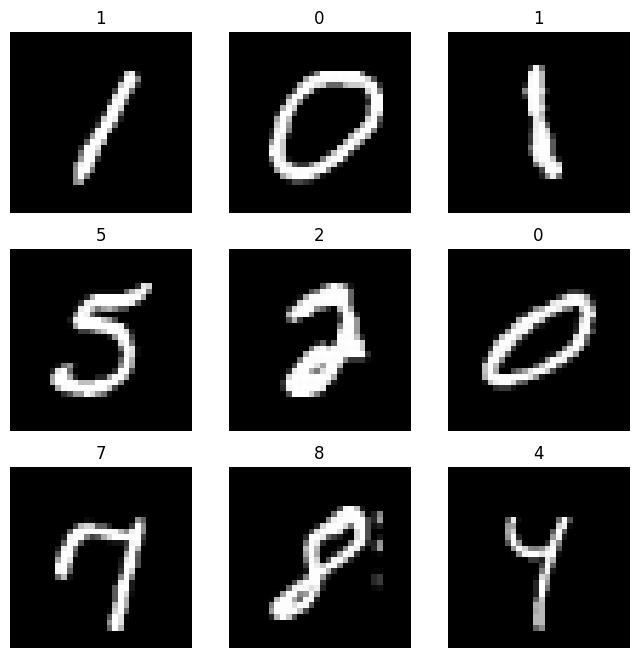

In [4]:
# Visualize a few random examples from the processed dataset

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### Model
#### Custom Layers
**<ins>Activation Function</ins>**<br />
Each layer up to FC6 is followed by a sigmoidal function, specifically the scaled hyperbolic tangent:
$$
    f(x) = A\:tanh(Sa)
$$
where $A$ is the amplitude of the function and $S$ is the slope of the function at the origin. The former is set in the paper to $A=1.1715$. The choice of this activation with the specific parameters is chosen to ensure faster convergence, but it's still more of a convenience - it doesn't change the result. More detailes are provided in Appendix A of the paper.

**<ins>Subsampling/Pooling Layers</ins>**<br />
As described previously, contrast to modern architectures, the subsampling layers in the paper have trainable parameters.
Existing implementations of LeNet-5 often use Average Pooling, which was popular during that time. However, the paper describes the subsampling layers in the following way:
- Each unit is connected to 2x2 window
- The 2x2 inputs are summed, then multiplied by a trainlable coefficient and added to a trainable bias
- The result is passed through the activation function

For simplicity, we perform the Average Pooling and then multiply back by the number of inputs.


**<ins>Output Layer</ins>**<br />
The output layer consists of 10 Euclidian RBF units. Each unit computes the Euclidian distance between the input vector and its parameter vector. Based on this, the loss function should be designed as to drive F6 as close as possible to the parameter vector of the RBF that corresponds to the pattern's desired class.
In the paper, the parameter vectors were chosen by hand to either -1 or +1 and kept fixed. They were designed to represent an image of the corresponding character on a 7x12 bitmap - this is the rationale for the 84 units in FC6.
This is useful for character recognition of ASCII, specifically for distingushing between similar charactrs, such as "O," "o" and "0" (uppercase O, lowercase o, zero).

Since we are interested only in digit recognition, we simplify the output layer slightly by keeping the parmaters learnable, rather than setting them to fixed values.

#### Weight Initialization  
The paper specifies that the weights should be initialized using a uniform distribution to ensure that the weighted sums of the inputs fall within the normal operating range of the sigmoid activation function. Specifically, weights are drawn from a uniform distribution:  
$$
w \sim \mathcal{U}\left(-\frac{2.4}{F_i}, \frac{2.4}{F_i}\right)
$$
where $F_i$ is the fan-in, or the number of inputs to a given unit. This initialization ensures that the initial standard deviation of the weighted sums remains consistent across units, regardless of the layer's fan-in size.  

The rationale behind this initialization is twofold:
1. **Avoiding Vanishing Gradients**: If the weights are too small, the gradients become negligible, slowing learning.  
2. **Avoiding Saturation**: If the weights are too large, the sigmoid activations become saturated, leading to very small gradients as well.  

This initialization is implemented for layers with trainable weights (e.g., fully connected and convolutional layers), while biases are initialized to zero for simplicity. 
The details of weight initialization are presented in Appendix A, along with the motivation for the use of the activation function.

Although this technique was a suitable choice for shallow networks and sigmoid activations, in modern architectures, deeper networks and activation functions like ReLU are used. These activations, in combination with more recent initialization techniques like He Initialization or Xavier Initialization, are designed to address the same problems but are more adapted to deep architectures. The approach described here was an important precursor to the understanding of the interaction between initialization, activation functions, and gradient flow that made modern advanced techniques possible everywhere.

In [5]:
# Custom Layers

# ScaledTanh - the activation used in the paper
# In modern architectures, this would typically be replaced by a ReLU or other activation
class ScaledTanh(nn.Module):
    def __init__(self, A=1.7159, S=2/3):
        super().__init__()
        self.A = A
        self.S = S

    def forward(self, x):
        output = self.A * torch.tanh(self.S * x)
        return output 


# Sumbsampling layer as described in the paper
# In modern architectures, this would typically be replaced by a pooling layer without trainable parameters
class Subsample(nn.Module):
    def __init__(self, in_channels):
        super(Subsample, self).__init__()
        self.in_channels = in_channels
        self.coefficients = nn.Parameter(torch.randn(in_channels), requires_grad=True)
        self.biases = nn.Parameter(torch.randn(in_channels), requires_grad=True)


    def forward(self, x):
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = x * (2*2) # multiply back to get only the sum
        output = torch.zeros_like(x) # avoid modifying x in-place
        for i in range(self.in_channels):
            output[:, i, :, :] = x[:, i, :, :] * self.coefficients[i] + self.biases[i] # (N, C, W, H)
        return output

# Simplified RBF layer
class RBF(nn.Module):
    def __init__(self, in_features, out_features):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centers = nn.Parameter(torch.randn(out_features, in_features)) # learnable params


    def forward(self, x):
        x_expanded = x.unsqueeze(1)
        centers_expanded = self.centers.unsqueeze(0)
        distances = torch.sum((x_expanded - centers_expanded) ** 2, dim=2)
        return distances

In [6]:
# Weight Initialization

def custom_weight_init(layer):
    if isinstance(layer, nn.Linear):
        fan_in = layer.weight.size(1) # number of input units
        bound = 2.4 / fan_in
        nn.init.uniform_(layer.weight, -bound, bound) # uniform distribution
        if layer.bias is not None: # initialize bias to zero
            nn.init.constant_(layer.bias, 0)

In [7]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.s2 = Subsample(in_channels=6)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.s4 = Subsample(in_channels=16)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        self.flatten = nn.Flatten()
        self.fc6 = nn.Linear(120, 84)
        self.output = RBF(in_features=84, out_features=num_classes)

        self.activation = ScaledTanh()

    # We'll write out the individual layers for easier debugging/inspection
    def forward(self, x):
        x = self.c1(x)
        x = self.activation(x)
        x = self.s2(x)
        x = self.activation(x)
        x = self.c3(x)
        x = self.activation(x)
        x = self.s4(x)
        x = self.activation(x)
        x = self.c5(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [8]:
model = LeNet5(num_classes=10).to(device)
model.apply(custom_weight_init)
summary(model, input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            156
├─ScaledTanh: 1-2                        [1, 6, 28, 28]            --
├─Subsample: 1-3                         [1, 6, 14, 14]            12
├─ScaledTanh: 1-4                        [1, 6, 14, 14]            --
├─Conv2d: 1-5                            [1, 16, 10, 10]           2,416
├─ScaledTanh: 1-6                        [1, 16, 10, 10]           --
├─Subsample: 1-7                         [1, 16, 5, 5]             32
├─ScaledTanh: 1-8                        [1, 16, 5, 5]             --
├─Conv2d: 1-9                            [1, 120, 1, 1]            48,120
├─ScaledTanh: 1-10                       [1, 120, 1, 1]            --
├─Flatten: 1-11                          [1, 120]                  --
├─Linear: 1-12                           [1, 84]                   10,164
├─S

⟹ This model has the exact same number of trainable parameters as the original paper, with the exception of C3 - this layer would originally have 1516 trainable paremeters due to the specific wiring pattern to the previous layer, which we do not use, as explained previously.

#### Loss Function
We implement the loss function as closely to the loss described in the paper by combining the MSE term (provided by the RBF output) and the logsumexp competetive term.

In [9]:
# Loss function
# Modern implementations simply use Cross-Entropy or similar loss

class CustomLoss(nn.Module):
    def __init__(self, num_classes, j=1.0):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.j = j

    def forward(self, distances, targets):
        correct_class_distances = distances.gather(1, targets.unsqueeze(1)).squeeze(1) # (batch_size,)

        log_sum_exp = torch.log(torch.exp(torch.tensor(-self.j)) + torch.sum(torch.exp(-distances), dim=1))  # (batch_size,)

        loss = (correct_class_distances + log_sum_exp).mean()

        return loss

### Training  
In a standard training setup, the dataset is typically split into three parts: a training set for model optimization, a validation set for performance monitoring and hyperparameter tuning, and a test set for final evaluation. However, for simplicity, we adopt a streamlined approach where we measure the test error after each epoch. In this case, the test set effectively serves as a validation set, though it is not used for hyperparameter tuning. This allows us to track the model’s generalization performance throughout training while keeping the implementation closer to the methodology described in the original paper.

In [10]:
# Train and test loops

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0.0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        batch_size = X.size(0)
        total_loss += loss.item() * batch_size
        correct += (pred.argmin(1) == y).type(torch.float).sum().item()

        # Progress update every 100 batches
        if batch % 100 == 0:
            current_loss = total_loss / ((batch + 1) * batch_size)
            current_acc = correct / ((batch + 1) * batch_size)
            print(f"[train] loss: {current_loss:>7f} | accuracy: {100*current_acc:>0.2f}% [{(batch+1)*batch_size:>5d}/{size:>5d}]")

    epoch_loss = total_loss / size
    epoch_acc = correct / size
    return epoch_loss, epoch_acc

def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    total_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            batch_size = X.size(0)
            
            total_loss += loss_fn(pred, y).item() * batch_size
            correct += (pred.argmin(1) == y).type(torch.float).sum().item()

    epoch_loss = total_loss / size
    epoch_acc = correct / size
    print(f"-----")
    print(f"[test] avg loss: {epoch_loss:>8f} | accuracy: {100*epoch_acc:>0.2f}%\n")
    return epoch_loss, epoch_acc


In [11]:
# Hyperparameters

batch_size = 64 # the original architecture would use 1, together with the SDLM optimizer
epochs = 20
num_classes = 10
loss_fn = CustomLoss(num_classes)
init_learning_rate = 0.0005
momentum = 0.8

def lr_schedule(epoch):
    if epoch < 2:
        return 1.0  # 0.0005
    elif epoch < 5:
        return 0.4  # 0.0002
    elif epoch < 8:
        return 0.2  # 0.0001
    elif epoch < 12:
        return 0.1  # 0.00005
    else:
        return 0.02  # 0.00001
    
optimizer = torch.optim.SGD(model.parameters(), lr=init_learning_rate, momentum=momentum) # SGD used for simplicity, as described previously
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)


In [12]:
# Dataloaders

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [13]:
metrics = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} | Learning Rate: {optimizer.param_groups[0]['lr']:.5f}")
    
    # train phase
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    metrics['train_loss'].append(train_loss)
    metrics['train_accuracy'].append(train_acc)
    
    # test phase
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    metrics['test_loss'].append(test_loss)
    metrics['test_accuracy'].append(test_acc)
    
    scheduler.step()

print("Training Complete!")


Epoch 1/20 | Learning Rate: 0.00050
[train] loss: 79.513153 | accuracy: 9.38% [   64/60000]
[train] loss: 49.755279 | accuracy: 51.02% [ 6464/60000]
[train] loss: 38.275288 | accuracy: 67.60% [12864/60000]
[train] loss: 31.596284 | accuracy: 75.25% [19264/60000]
[train] loss: 26.997373 | accuracy: 79.65% [25664/60000]
[train] loss: 23.871520 | accuracy: 82.38% [32064/60000]
[train] loss: 21.453377 | accuracy: 84.50% [38464/60000]
[train] loss: 19.611817 | accuracy: 86.00% [44864/60000]
[train] loss: 18.159053 | accuracy: 87.12% [51264/60000]
[train] loss: 16.870802 | accuracy: 88.11% [57664/60000]
-----
[test] avg loss: 6.649803 | accuracy: 95.62%

Epoch 2/20 | Learning Rate: 0.00050
[train] loss: 6.118330 | accuracy: 95.31% [   64/60000]
[train] loss: 5.780147 | accuracy: 96.21% [ 6464/60000]
[train] loss: 6.002672 | accuracy: 95.83% [12864/60000]
[train] loss: 5.849225 | accuracy: 95.96% [19264/60000]
[train] loss: 5.632120 | accuracy: 96.08% [25664/60000]
[train] loss: 5.528456 | ac

In [14]:
torch.save(model.state_dict(), 'model.pth')

### Results
#### Loss and Accuracy
Our implementation achieved a final test accuracy of **98.6%** (best result) with a test loss of **1.93**, compared to the original paper's 0.95% error rate (99.05% accuracy) on undistorted data. Key observations:
- **Training Stability**: As shown in the loss curves below, the model stabilized after ~10 epochs, mirroring the behavior described in the original paper
- **Generalization Gap**: The test accuracy remained very close to training accuracy, suggesting low overfitting 
- **Learning Rate Impact**: The scheduled learning rate helped avoid plateaus, though without the SDLM optimizer's adaptive per-parameter rates, convergence was slower than described in Appendix C

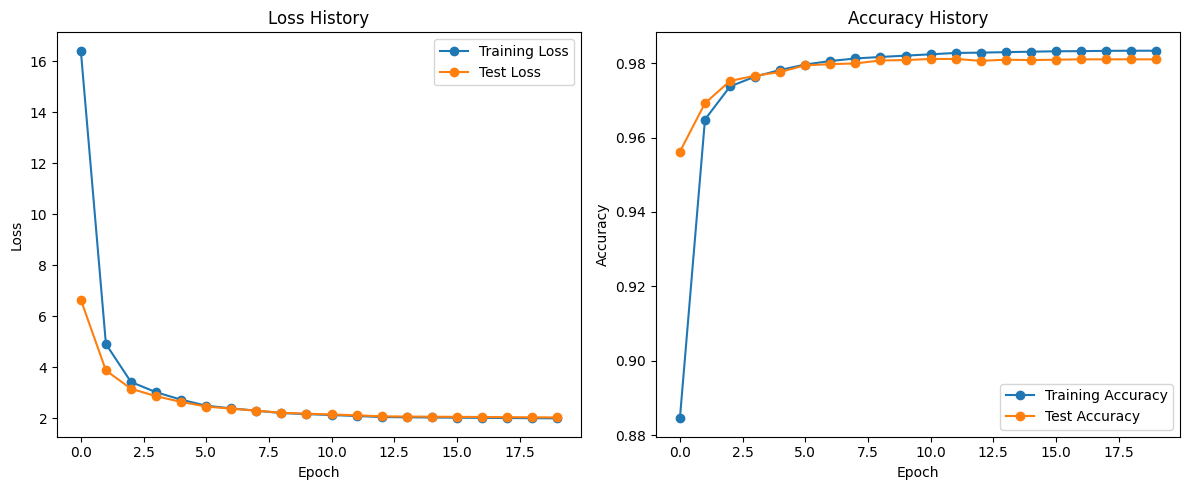

In [16]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Training Loss', marker='o')
plt.plot(metrics['test_loss'], label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(metrics['train_accuracy'], label='Training Accuracy', marker='o')
plt.plot(metrics['test_accuracy'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()


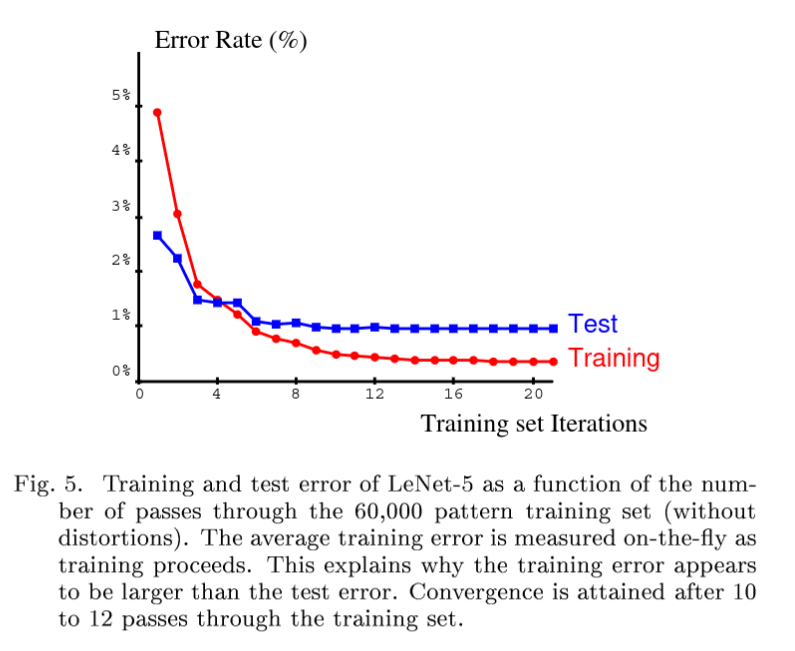


#### Confusion Matrix & Failure Cases
Let's plot the confusion matrix and some of the misclassified examples to see where the model makes the most mistakes. Due to the high accuracy of the model, we'll adjust the confusion matrix to visualize the results better by normalizing it and masking out the main diagonal. 

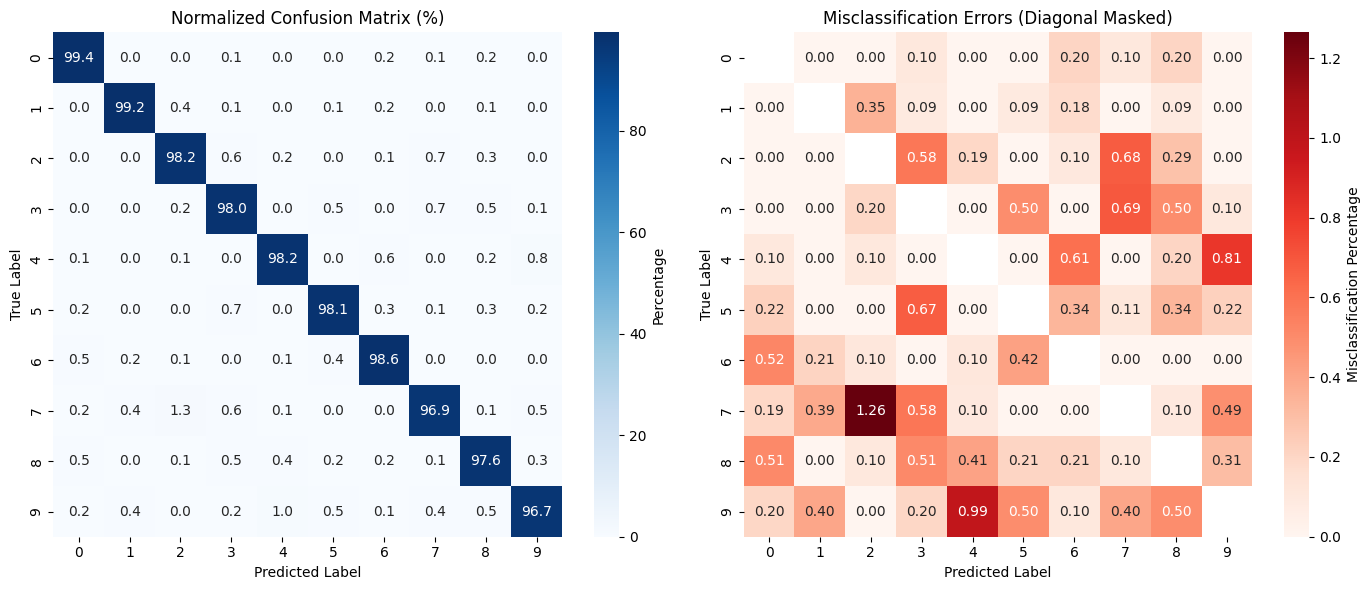

In [17]:
# Collect predictions and true labels from the test set
all_preds = []
all_true = []
for X, y in test_dataloader:
    X = X.to(device)
    outputs = model(X)
    preds = outputs.argmin(1).cpu().numpy()  # RBF - prediction is given by the class with the lowest distance
    all_preds.extend(preds)
    all_true.extend(y.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_true, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # row-wise normalization

# Create a misclassification matrix by masking the diagonal
cm_misclass = cm_normalized.copy()
np.fill_diagonal(cm_misclass, np.nan)  # Mask out the main diagonal

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized * 100, annot=True, fmt=".1f", cmap='Blues', cbar_kws={'label': 'Percentage'}, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Normalized Confusion Matrix (%)')

# Plot the misclassification matrix
sns.heatmap(cm_misclass * 100, annot=True, fmt=".2f", cmap='Reds', cbar_kws={'label': 'Misclassification Percentage'}, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Misclassification Errors (Diagonal Masked)')

plt.tight_layout()
plt.show()

We can see the most common mistakes are confusing 6 and 0, 2 and 7, 3 and 5, ... which seems sensible.
Let's plot some of specific misclassified instances for better understanding:

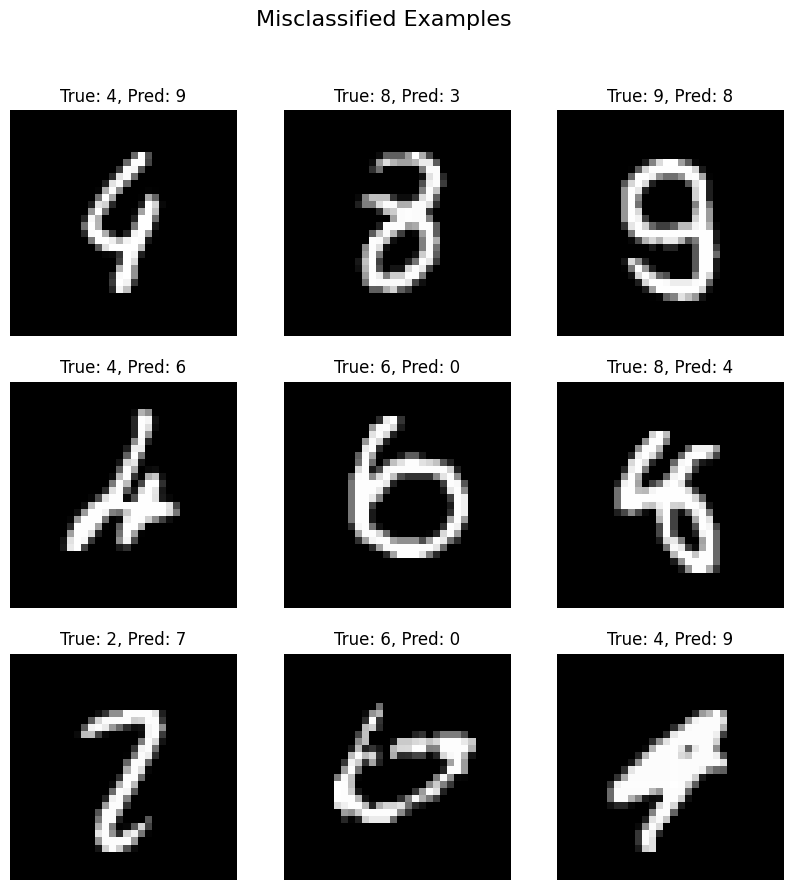

In [18]:
misclassified_images = []
misclassified_preds = []
misclassified_true = []

# Collect misclassified samples
for X, y in test_dataloader:
    X = X.to(device)
    outputs = model(X)
    preds = outputs.argmin(dim=1)
    mis_mask = preds != y.to(device)
    if mis_mask.sum() > 0:
        for i in range(X.size(0)):
            if mis_mask[i]:
                misclassified_images.append(X[i].cpu())
                misclassified_preds.append(preds[i].item())
                misclassified_true.append(y[i].item())

plt.figure(figsize=(10, 10))
for i in range(min(9, len(misclassified_images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
    plt.title(f"True: {misclassified_true[i]}, Pred: {misclassified_preds[i]}")
    plt.axis('off')
plt.suptitle('Misclassified Examples', fontsize=16)
plt.show()

### Conclusion
In this notebook, we implemented an authentic version of LeNet based on the original paper. While many modern implementations of LeNet have simplified or modernized certain components (e.g., replacing trainable pooling with fixed average/max pooling, using ReLU activations), our implementation strives to adhere closely to the original architecture. Key implementation differences:
| Component               | Original Paper          | Our Implementation     | Rationale               |
|-------------------------|-------------------------|------------------------|-------------------------|
| **C3 Connections**      | Sparse feature map links| Full connections       | Simplified implementation |
| **Optimizer**           | SDLM (Appendix C)       | SGD with momentum      | Implementation complexity|
| **RBF Centers**         | Hand-crafted 7x12 bitmaps| Learned parameters     | ASCII focus not needed   |
| **Subsampling**         | Trainable coeff/bias    | Fixed avg pool + scale | Numerical stability      |

**<ins>Summary of Results</ins>**<br />
The training and test curves show steady convergence, and the confusion matrix highlights that the model is generally accurate but tends to confuse similar digits, which is expected. Due to our simplicifations, we don't achieve the exact same results as the original paper, but the performance is very good.

**<ins>Reflection on the Historical Context</ins>**<br />
While LeNet was groundbreaking in its time—introducing convolutional layers, weight sharing, and specialized pooling mechanisms, many of its components are now considered outdated:
- **RBF Output Layer**: Replaced by softmax + cross-entropy due to better probabilistic interpretation
- **Sigmoidal Activations**: Superseded by ReLU for better gradient flow
- **Trainable Pooling**: Abandoned in favor of fixed pooling (max/average) for reduced complexity
- **Optimization**: The original SDLM method addressed issues in early neural networks but is computationally intensive compared to modern optimizers, such as SGD or Adam.

Despite simpler components, the convolutional paradigm alone achieves >98 % accuracy - the core CNN pattern remains ubiquitous:
```python
Conv -> Pool -> Conv -> Pool -> FC -> Output
```

Despite these differences, revisiting LeNet provides important insights into the evolution of neural network design. This implementation aims to not only honor these historical foundations but also serve as a bridge to understanding how far the field has advanced.

**<ins>Potential Future Work</ins>**<br />
Here are some ideas for future extensions of this implementation:
- **SDLM Optimizer Implementation**: Replicate the paper's Stochastic Diagonal Levenberg-Marquardt method using Hessian diagonal approximation
- **Data Augmentation with Artificial Distortions**: Add affine transformations to training data to test robustness claims
- **Fixed RBF Center**: Initialize output layer with stylized 7x12 bitmap patterns as described in Section II-B
- **More Detailed/Systematic Analysis**: Analysing the impact of individual components and design choices, systematic hyperparameter tuning, ...
- **Visualization Improvement**: e.g. t-SNE plots for better understanding of the internal representations

---
If you have any questions, ideas, or feedback, feel free to reach out:  
🐦 **𝕏:** [@matejhladky_dev](https://x.com/matejhladky_dev)<br />
📧 **Email:** mat.gladky@gmail.com

I'm always happy to chat!